# Analyse avec K-means

**But :** Trouver les différents clusters depuis les images précédements extraites des vidéos

In [1]:
from os import listdir

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.io import read_image
import torchvision

from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_samples, silhouette_score

import skimage.transform

### Dataset

In [2]:
img_path = "./data/videos/labelised/all"

In [20]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, device='cpu'):
        self.img_dir = img_dir
        self.imgs_path = [f"{img_dir}/{img}" for img in listdir(self.img_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image).to(device)
        return image

In [21]:
transform = T.Compose([T.Resize((224,224))])

### CNN

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
dataset = ImageDataset(img_dir=img_path, transform=transform, device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
vgg16_model = torchvision.models.vgg16(pretrained=True)

vgg16_model.to(device)

for param in vgg16_model.parameters():
    param.requires_grad = False

In [27]:
dataloader_iter = iter(dataloader)
features = next(dataloader_iter).float()
features.shape

torch.Size([32, 3, 224, 224])

In [33]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [28]:
vgg16_model.eval()
out = vgg16_model(features)
print(out)

tensor([[-37.7165,  -7.4064,  -8.3867,  ..., -49.1436,   7.4942,  15.0046],
        [-45.3138, -13.6956, -12.8071,  ..., -52.3505,  11.0222,  29.1874],
        [-45.9073, -11.5218, -12.9465,  ..., -63.2153,  11.8120,  46.6887],
        ...,
        [-44.0130,  -9.5372, -14.0247,  ..., -62.2812,  11.2262,  45.9744],
        [-54.9048, -21.6019, -12.4815,  ..., -57.6195,   5.8695,  44.4755],
        [-45.2998, -14.6879, -14.2129,  ..., -54.0753,   8.2896,  37.7919]],
       device='cuda:0')


In [31]:
out_cpu = out.cpu()
prediction = out_cpu.detach().numpy()
predict_max = np.argmax(prediction)
predict_max

21818

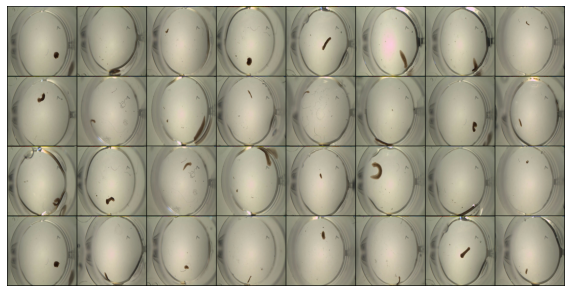

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs):
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

test = next(iter(dataloader))
show_databatch(test)

### ACP

In [6]:
ipca = IncrementalPCA(n_components=50, batch_size=100)
X_ipca = ipca.fit_transform(dataset)
var = ipca.explained_variance_ratio_.cumsum()

variance preserved by 50 components: 0.894


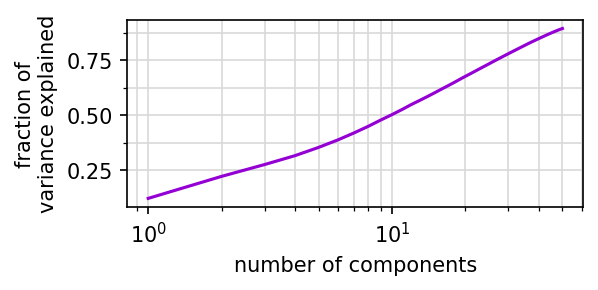

In [9]:


fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var)+1), var, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)


fig.tight_layout()
print('variance preserved by 50 components: {:.3f}'.format(var[49]))

### Clustering

Determiner les K clusters avec TSNE

In [34]:
def get_k_clusters(range_max, X):
    range_n_clusters = range(2, range_max)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=30, max_iter=600)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" %
                        i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()


For n_clusters = 2 The average silhouette_score is : 0.11527427455401837
For n_clusters = 3 The average silhouette_score is : 0.13873567337463708
For n_clusters = 4 The average silhouette_score is : 0.12662489799248441
For n_clusters = 5 The average silhouette_score is : 0.14418226870105005
For n_clusters = 6 The average silhouette_score is : 0.16248525049445808
For n_clusters = 7 The average silhouette_score is : 0.16999575758178426
For n_clusters = 8 The average silhouette_score is : 0.1806866212729911
For n_clusters = 9 The average silhouette_score is : 0.20195419071120838
For n_clusters = 10 The average silhouette_score is : 0.21656381855699666
For n_clusters = 11 The average silhouette_score is : 0.1961118790595508


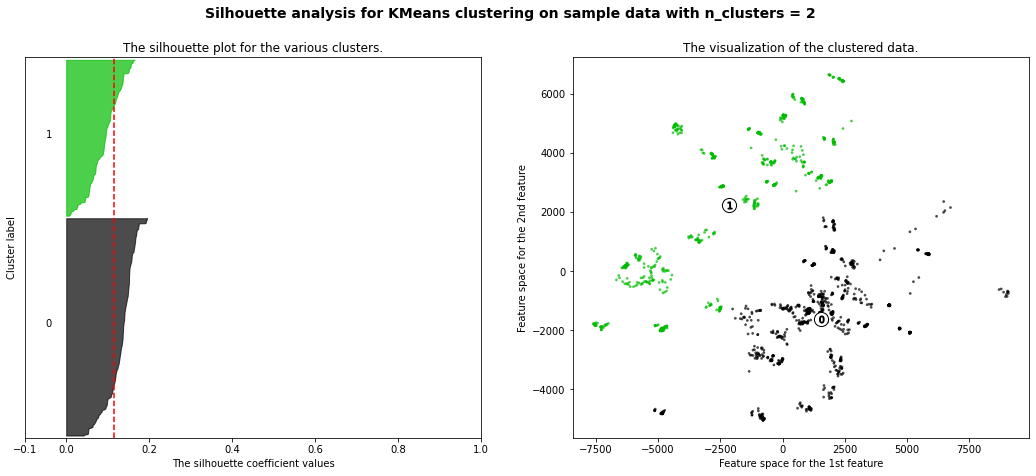

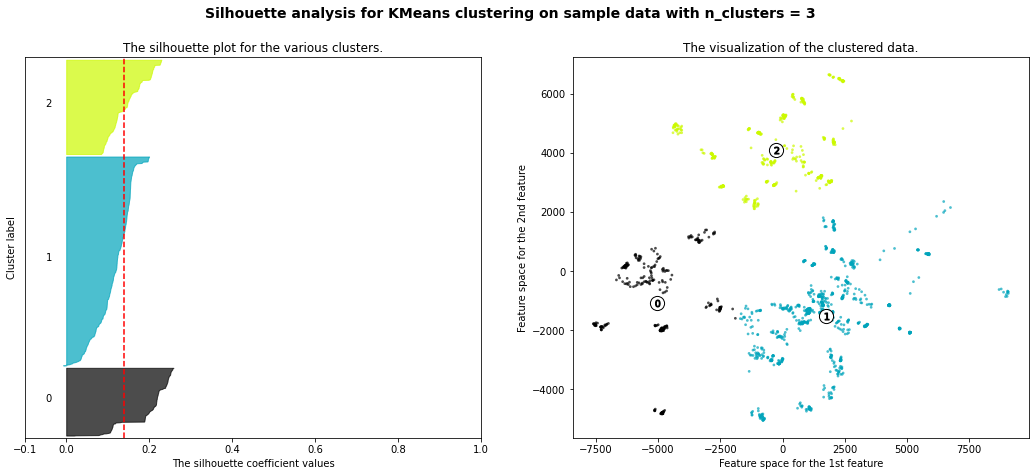

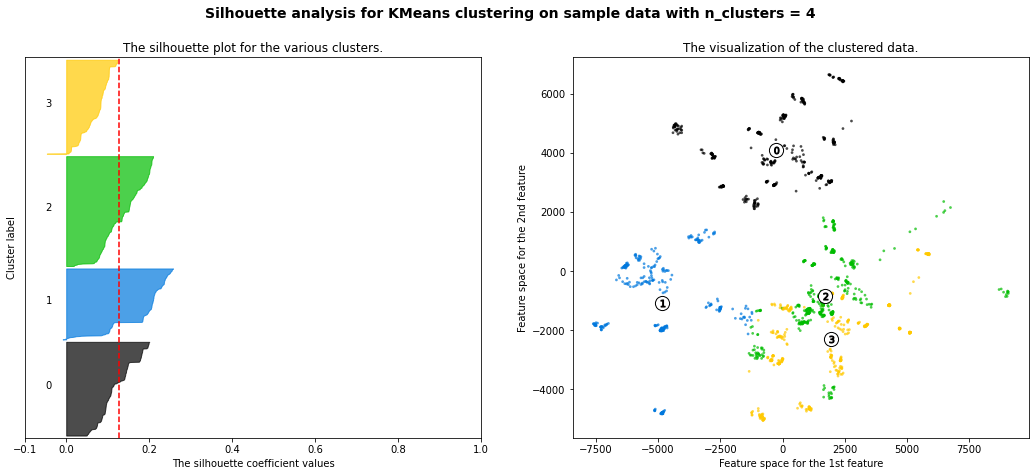

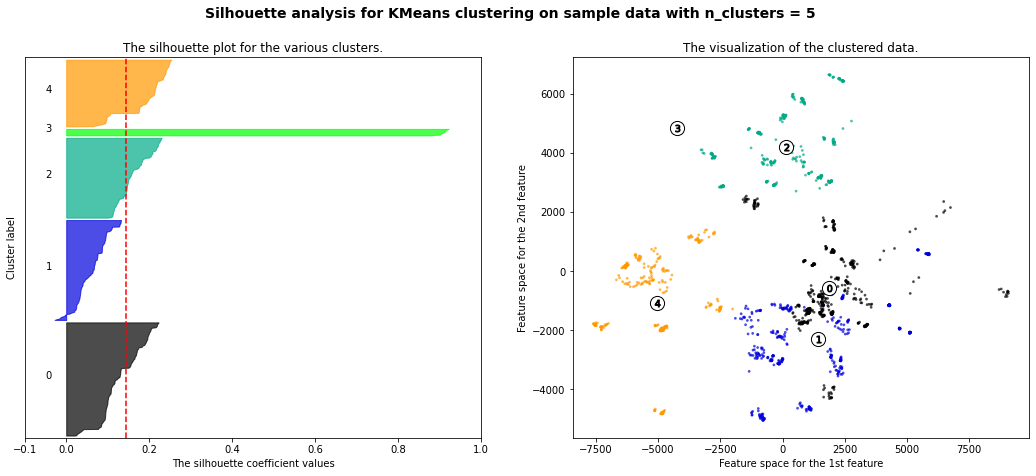

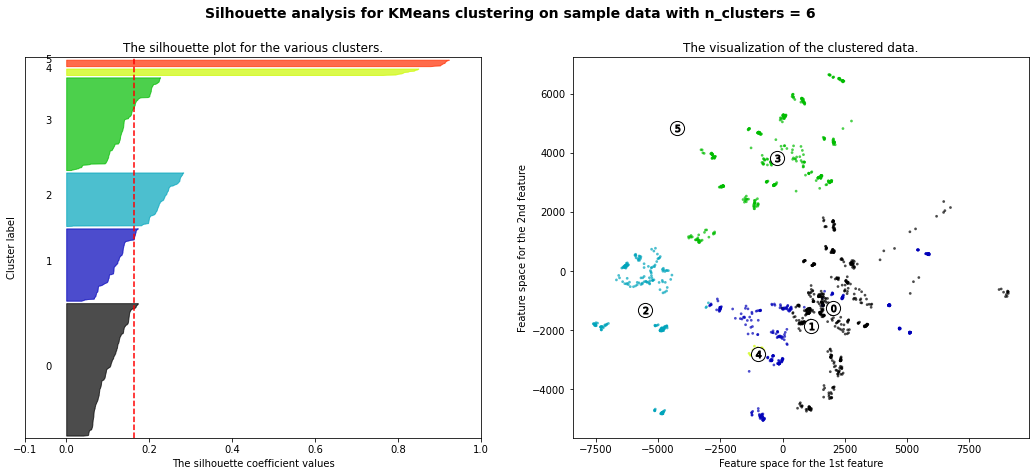

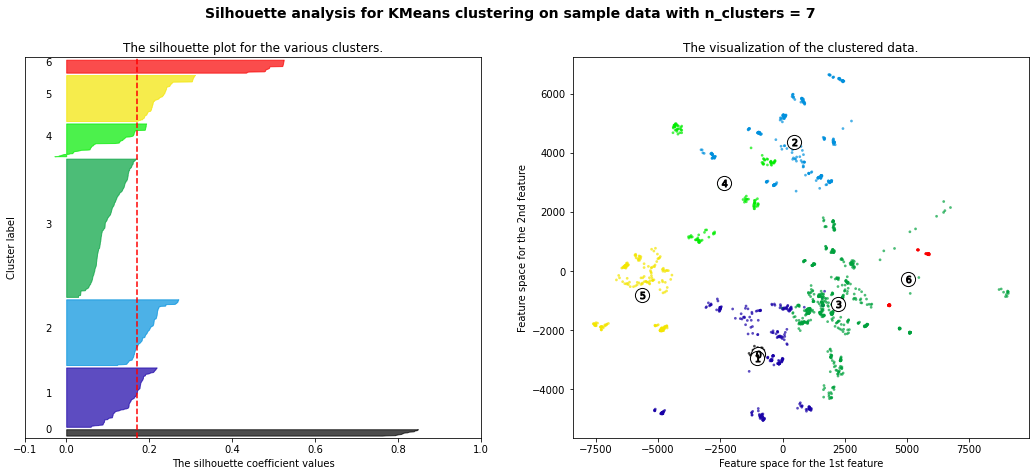

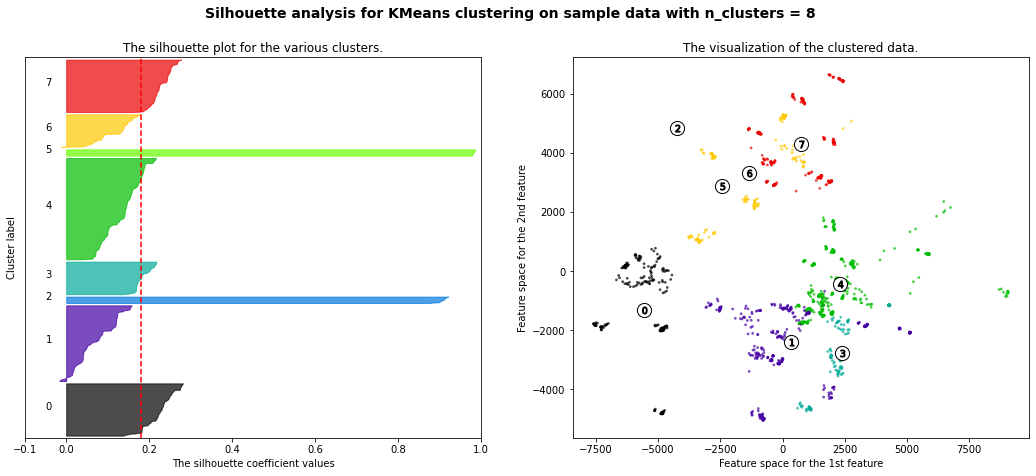

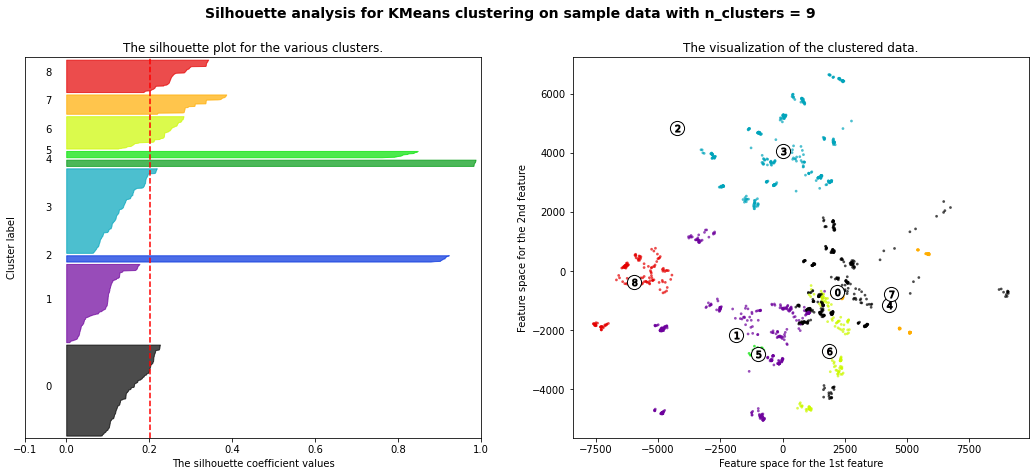

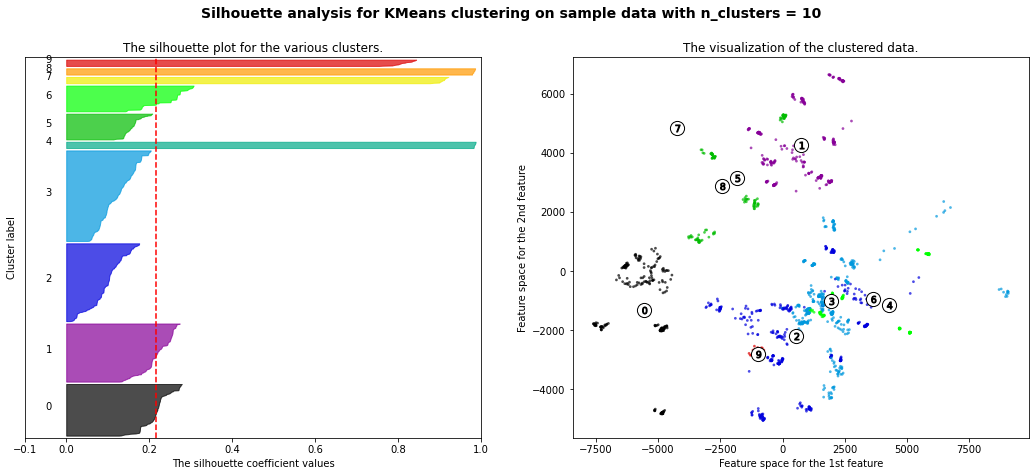

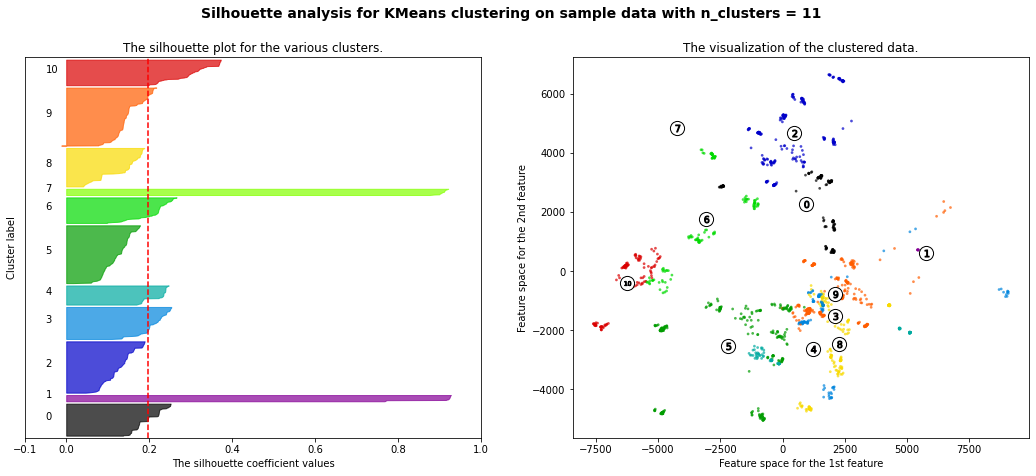

In [40]:
get_k_clusters(12,X_ipca)

In [29]:
K = range(6,25)
squared_dist = {}

for k in K:
    print(k)
    kmeans = KMeans(init='k-means++', n_init=100, max_iter=600)
    kmeans.fit(X_ipca)
    squared_dist[k] = kmeans.inertia_

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [31]:
nb_clusters = min(squared_dist, key=squared_dist.get)
nb_clusters

76710099395.1783

In [23]:
kmeans = KMeans(n_clusters=nb_clusters, init='k-means++', n_init=30, max_iter=600)
kmeans.fit(X_ipca)

KMeans(max_iter=600, n_clusters=10, n_init=30)

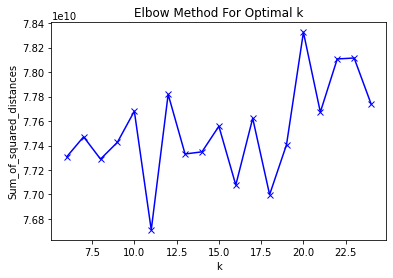

In [32]:
plt.plot(K, squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

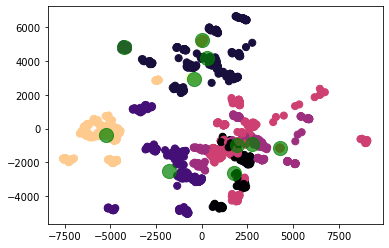

In [27]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.scatter(X_ipca[:, 0], X_ipca[:, 1], c=labels, s=50, cmap='magma')
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.7)